#Importing Packages and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import keras
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from keras.utils import to_categorical
from keras.utils import np_utils
import seaborn as sns

In [3]:
!unzip '/content/train.zip' -d '/content/cifar100_nl/img/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cifar100_nl/img/train/XJMrYyxYmo.png  
  inflating: /content/cifar100_nl/img/train/xjMWgyntNq.png  
  inflating: /content/cifar100_nl/img/train/xJMYnqiuIe.png  
  inflating: /content/cifar100_nl/img/train/XJNvQMfwBV.png  
  inflating: /content/cifar100_nl/img/train/XjOqBKaedY.png  
  inflating: /content/cifar100_nl/img/train/XjOUgoUEdZ.png  
  inflating: /content/cifar100_nl/img/train/XjOuyQVrhz.png  
  inflating: /content/cifar100_nl/img/train/xjrDjsxvmC.png  
  inflating: /content/cifar100_nl/img/train/xjrRGuMdYW.png  
  inflating: /content/cifar100_nl/img/train/xjryxNIsxg.png  
  inflating: /content/cifar100_nl/img/train/xjSxvAtWJl.png  
  inflating: /content/cifar100_nl/img/train/xJSYBfhaon.png  
  inflating: /content/cifar100_nl/img/train/XjtjiFzwdx.png  
  inflating: /content/cifar100_nl/img/train/xJUySUqOgJ.png  
  inflating: /content/cifar100_nl/img/train/XjVAstEnkw.png  
  inflating: /content/cifar100_nl/

In [4]:
train = pd.read_csv("/content/cifar100_nl.csv", header = None)

In [5]:
testLabels = pd.read_csv("/content/cifar100_nl_test.csv", header = None)

In [6]:
trainLabels = train[0:49999]

In [7]:
train_image = []
for i in tqdm(range(trainLabels.shape[0])):
    img = tf.keras.utils.load_img('/content/'+trainLabels[0][i], target_size=(32,32,3), grayscale=False)
    img = tf.keras.utils.img_to_array(img)
    train_image.append(img)
x_train = np.array(train_image)

100%|██████████| 49999/49999 [00:11<00:00, 4477.39it/s]


In [8]:
test_image = []
for i in tqdm(range(testLabels.shape[0])):
    img = tf.keras.utils.load_img('/content/'+testLabels[0][i], target_size=(32,32,3), grayscale=False)
    img = tf.keras.utils.img_to_array(img)
    test_image.append(img)
x_test = np.array(test_image)

100%|██████████| 9999/9999 [00:02<00:00, 4389.37it/s]


#Pre-processing

In [9]:
x_test /=255
x_train /= 255

In [10]:
y_train = trainLabels[1]
y_test = testLabels[1]

In [11]:
y_train.astype('category')
y_test.astype('category')

0             forest
1       pickup_truck
2              skunk
3               rose
4             orange
            ...     
9994           shark
9995           couch
9996            seal
9997       pine_tree
9998          rocket
Name: 1, Length: 9999, dtype: category
Categories (100, object): ['apple', 'aquarium_fish', 'baby', 'bear', ..., 'willow_tree', 'wolf',
                           'woman', 'worm']

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labeltrain = le.fit_transform(y_train)
labeltest = le.fit_transform(y_test)

n_classes = 100
y_train = to_categorical(labeltrain, n_classes)
y_test = to_categorical(labeltest, n_classes)

##Imbalance Classes

In [13]:
new_x_train = x_train
new_x_train = new_x_train.reshape(new_x_train.shape[0],(32 * 32 * 3))
new_x_train = new_x_train.astype('float32')
print(new_x_train.shape)
new_x_train

(49999, 3072)


array([[1.        , 1.        , 0.78039217, ..., 0.99215686, 1.        ,
        0.99215686],
       [0.654902  , 0.6745098 , 0.7529412 , ..., 0.49019608, 0.49803922,
        0.58431375],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.18431373, 0.61960787, 0.20784314, ..., 0.12941177, 0.5372549 ,
        0.15686275],
       [0.1254902 , 0.15294118, 0.12941177, ..., 0.00392157, 0.02745098,
        0.02352941],
       [0.6156863 , 0.47843137, 0.41568628, ..., 0.5176471 , 0.7607843 ,
        0.99215686]], dtype=float32)

###UnderSampling

In [ ]:
import imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(new_x_train, y_train)

print('original dataset shape:', y_train.shape)
print('Resample dataset shape', y_rus.shape)

original dataset shape: (49999, 100)
Resample dataset shape (46800, 100)


In [ ]:
x_rus = x_rus.reshape(x_rus.shape[0],32 ,32 ,3)
x_rus = x_rus.astype('float32')

In [ ]:
x_rus.shape

(46800, 32, 32, 3)

###OverSampling

In [14]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_ros, y_ros = oversample.fit_resample(new_x_train, y_train)

print('Original dataset shape', y_train.shape)
print('Resample dataset shape', y_ros.shape)

Original dataset shape (49999, 100)
Resample dataset shape (53500, 100)


In [15]:
x_ros = x_ros.reshape(x_ros.shape[0],32 ,32 ,3)
x_ros = x_ros.astype('float32')
x_ros.shape

(53500, 32, 32, 3)

##Data Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [17]:
x_train_split, x_validation, y_train_split, y_validation = train_test_split(x_ros, y_ros, test_size=0.2, random_state=123)

In [18]:

#data_gen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)
data_gen = ImageDataGenerator(
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            featurewise_center=True,
            width_shift_range=0.1,
            validation_split=0.2)

data_gen.fit(x_train_split)

train_data_gen = data_gen.flow(x_train_split, y_train_split, batch_size=128)


##Grayscaling Data

In [ ]:
from skimage import color
from skimage import io

In [ ]:
train_image_gray = []
for i in tqdm(range(trainLabels.shape[0])):
    img = io.imread('/content/'+trainLabels[0][i])
    imgGray = color.rgb2gray(img)
    imgGray = tf.keras.utils.img_to_array(imgGray)
    train_image_gray.append(imgGray)
x_train_gray = np.array(train_image_gray)

100%|██████████| 49999/49999 [00:49<00:00, 1016.55it/s]


In [ ]:
test_image_gray = []
for i in tqdm(range(testLabels.shape[0])):
    img = io.imread('/content/'+testLabels[0][i])
    imgGray = color.rgb2gray(img)
    imgGray = tf.keras.utils.img_to_array(imgGray)
    test_image_gray.append(imgGray)
x_test_gray = np.array(test_image_gray)

100%|██████████| 9999/9999 [00:09<00:00, 1046.27it/s]


In [ ]:
x_test_gray.shape

(9999, 32, 32, 1)

###OverSampling

In [ ]:
new_x_train_gray = x_train_gray
new_x_train_gray = new_x_train_gray.reshape(new_x_train_gray.shape[0],(32 * 32 * 1))
new_x_train_gray = new_x_train_gray.astype('float32')
print(new_x_train_gray.shape)
new_x_train_gray

(49999, 1024)


array([[0.98416626, 0.9729521 , 0.9768737 , ..., 0.8075824 , 0.9490345 ,
        0.99776787],
       [0.67599803, 0.65917295, 0.6630945 , ..., 0.5392937 , 0.53760433,
        0.5025929 ],
       [1.        , 1.        , 0.9971945 , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.4974196 , 0.49461412, 0.49461412, ..., 0.42540902, 0.42708352,
        0.42316195],
       [0.14541137, 0.1280506 , 0.18883844, ..., 0.17175333, 0.04823529,
        0.02216824],
       [0.5030741 , 0.52249724, 0.46164548, ..., 0.72333527, 0.71873724,
        0.7257996 ]], dtype=float32)

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_ros_gray, y_ros_gray = oversample.fit_resample(new_x_train_gray, y_train)

print('Original dataset shape', y_train.shape)
print('Resample dataset shape', y_ros_gray.shape)

Original dataset shape (49999, 100)
Resample dataset shape (53500, 100)


In [ ]:
x_ros_gray = x_ros_gray.reshape(x_ros_gray.shape[0],32 ,32 ,1)
x_ros_gray = x_ros_gray.astype('float32')
x_ros_gray.shape

(53500, 32, 32, 1)

#Plots

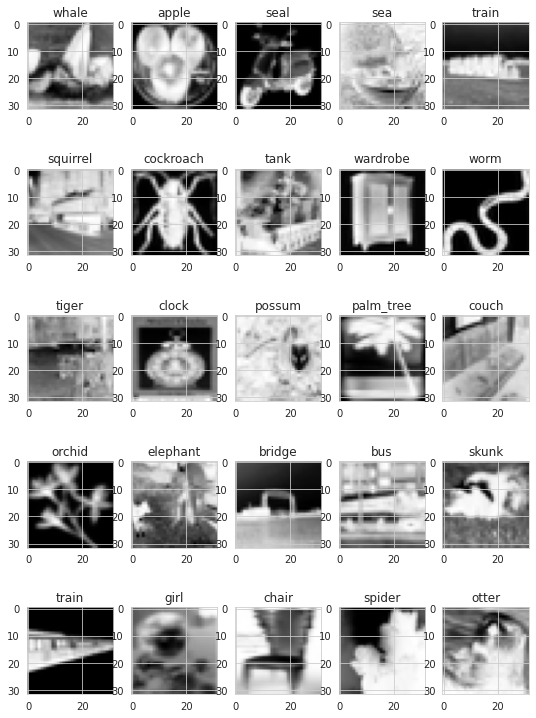

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 5
rows = 5
ax = []

for i in range(1, columns*rows +1):
  image = x_train_gray[i]
  ax.append( fig.add_subplot(rows, columns, i) )
  ax[-1].set_title(trainLabels[1][i])
  plt.imshow(image.reshape(32,32), cmap="Greys")
plt.show()
plt.close()

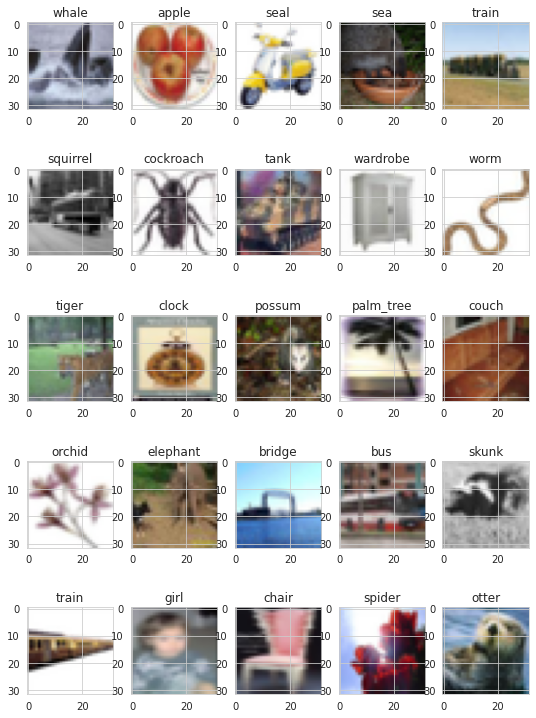

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 5
rows = 5
ax = []

for i in range(1, columns*rows +1):
  image = x_train[i]
  ax.append( fig.add_subplot(rows, columns, i) )
  ax[-1].set_title(trainLabels[1][i])
  plt.imshow(image)
plt.show()
plt.close()

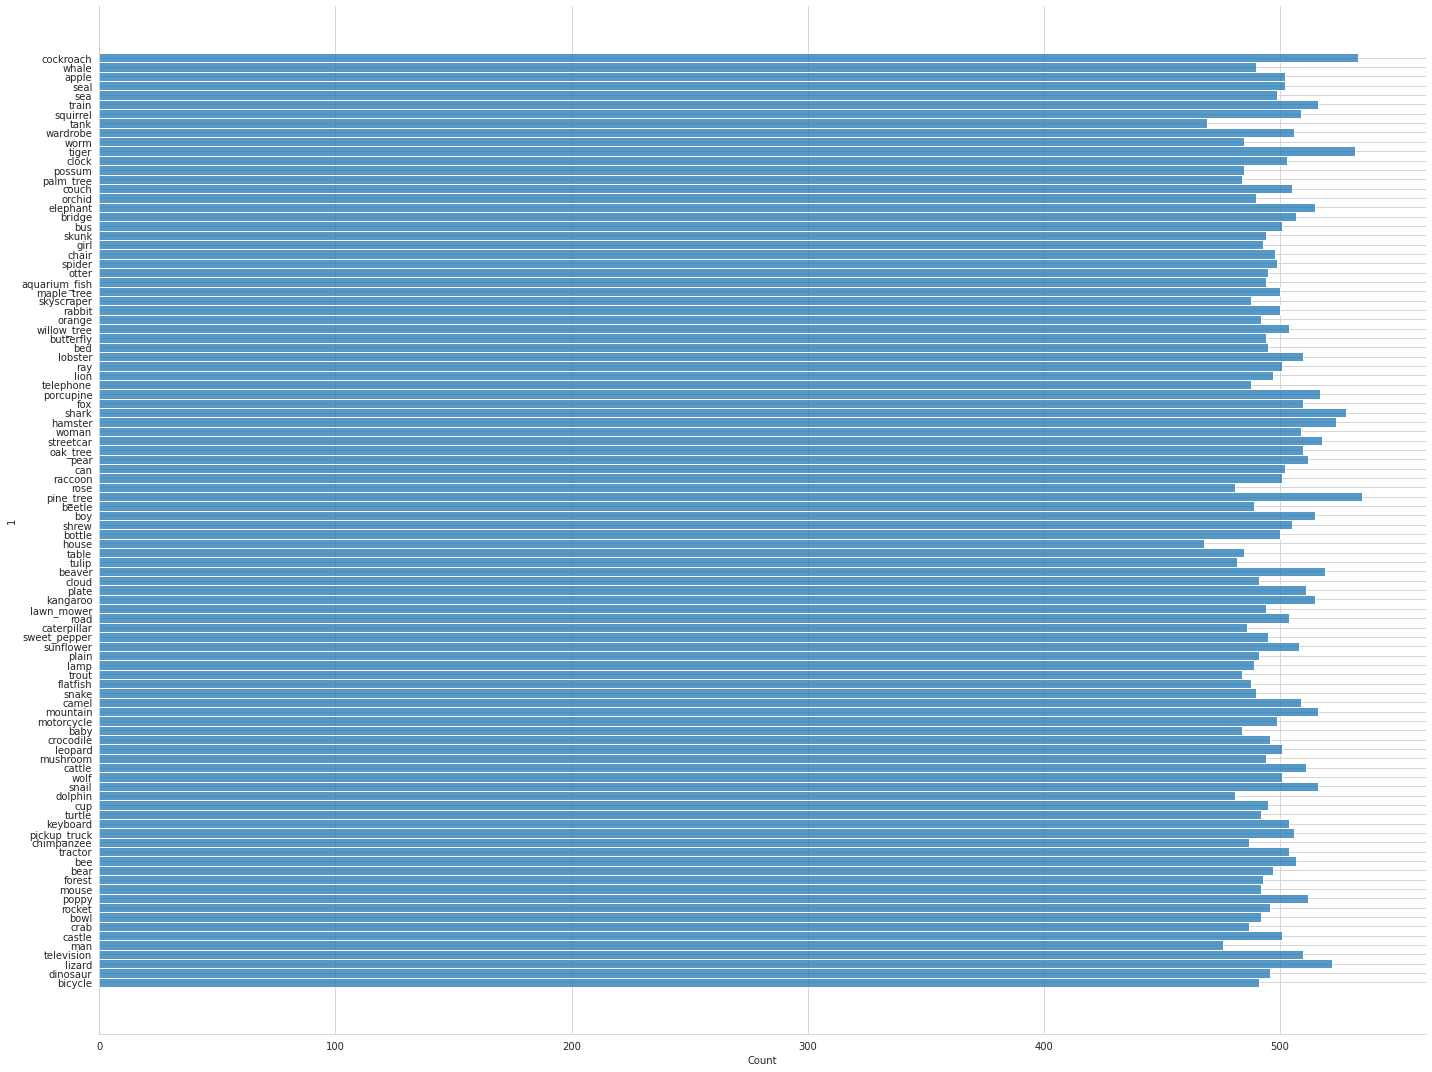

In [ ]:
sns.set_style('whitegrid')
sns.displot(y=trainLabels[1], height=15, aspect=20/15 )

#Convolutional Neural Network

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()

model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))   

model.add(Conv2D(512, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))

#model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size = (2,2)))
#model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(100, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                        

In [ ]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate=1e-4))

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
history = model.fit(x_ros, y_ros, validation_split = 0.2, shuffle = True, epochs=350, batch_size=128, callbacks=[es])

Epoch 1/350
335/335 [==============================] - 48s 138ms/step - loss: 5.7221 - accuracy: 0.0221 - val_loss: 5.0687 - val_accuracy: 0.0093
Epoch 2/350
335/335 [==============================] - 44s 131ms/step - loss: 5.1123 - accuracy: 0.0409 - val_loss: 4.3574 - val_accuracy: 0.0560
Epoch 3/350
335/335 [==============================] - 44s 130ms/step - loss: 4.8040 - accuracy: 0.0571 - val_loss: 4.1075 - val_accuracy: 0.1071
Epoch 4/350
335/335 [==============================] - 44s 130ms/step - loss: 4.5994 - accuracy: 0.0739 - val_loss: 4.0658 - val_accuracy: 0.1111
Epoch 5/350
335/335 [==============================] - 44s 130ms/step - loss: 4.4518 - accuracy: 0.0876 - val_loss: 4.0513 - val_accuracy: 0.1249
Epoch 6/350
335/335 [==============================] - 44s 130ms/step - loss: 4.3261 - accuracy: 0.1045 - val_loss: 3.9927 - val_accuracy: 0.1409
Epoch 7/350
335/335 [==============================] - 44s 130ms/step - loss: 4.2376 - accuracy: 0.1154 - val_loss: 3.9124 -

In [ ]:
history = model.fit(train_data_gen, steps_per_epoch=43000//128, validation_data=(x_validation, y_validation), callbacks=[es], epochs=350)

Epoch 1/350
335/335 [==============================] - 59s 141ms/step - loss: 5.6950 - accuracy: 0.0235 - val_loss: 5.0799 - val_accuracy: 0.0160
Epoch 2/350
335/335 [==============================] - 45s 136ms/step - loss: 5.1048 - accuracy: 0.0390 - val_loss: 4.7117 - val_accuracy: 0.0305
Epoch 3/350
335/335 [==============================] - 47s 140ms/step - loss: 4.8400 - accuracy: 0.0523 - val_loss: 4.7179 - val_accuracy: 0.0338
Epoch 4/350
335/335 [==============================] - 47s 140ms/step - loss: 4.6764 - accuracy: 0.0655 - val_loss: 4.5256 - val_accuracy: 0.0499
Epoch 5/350
335/335 [==============================] - 46s 136ms/step - loss: 4.5434 - accuracy: 0.0775 - val_loss: 4.4415 - val_accuracy: 0.0559
Epoch 6/350
335/335 [==============================] - 45s 134ms/step - loss: 4.4442 - accuracy: 0.0858 - val_loss: 4.4958 - val_accuracy: 0.0535
Epoch 7/350
335/335 [==============================] - 46s 136ms/step - loss: 4.3410 - accuracy: 0.0990 - val_loss: 4.4009 -

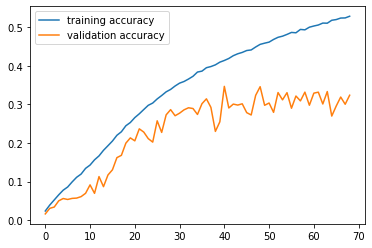

In [ ]:
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

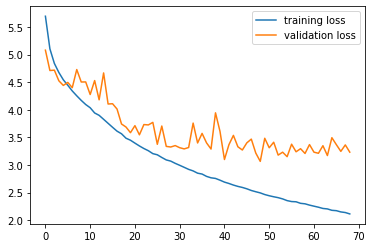

In [ ]:
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [ ]:
print("Evaluate model on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate model on test data
79/79 [==============================] - 6s 40ms/step - loss: 2.4180 - accuracy: 0.4128
test loss, test acc: [2.418046474456787, 0.4128412902355194]


In [ ]:
print("Evaluate model on test data")
results = model.evaluate(data_gen.flow(x_test, y_test), steps=10000//128)
print("test loss, test acc:", results)

Evaluate model on test data
78/78 [==============================] - 2s 25ms/step - loss: 1.5819 - accuracy: 0.5913
test loss, test acc: [1.5818543434143066, 0.5913461446762085]


#Transfer Learning

##ResNet50

In [44]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D

In [45]:
resnet = ResNet50(weights='imagenet', include_top=False)

for layer in resnet.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


In [46]:
model = Sequential()

model.add(UpSampling2D(size=(7, 7), interpolation='bilinear', input_shape=(32, 32, 3)))

model.add(resnet)

model.add(GlobalAveragePooling2D())

#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(100, activation='softmax'))

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_3 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [48]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
history = model.fit(train_data_gen, steps_per_epoch=100, validation_data=(x_validation, y_validation), epochs=20)

Epoch 1/20
100/100 [==============================] - 128s 1s/step - loss: 4.1329 - accuracy: 0.1638 - val_loss: 5.3222 - val_accuracy: 0.0106
Epoch 2/20
100/100 [==============================] - 124s 1s/step - loss: 3.3012 - accuracy: 0.3024 - val_loss: 5.5142 - val_accuracy: 0.0093
Epoch 3/20
100/100 [==============================] - 124s 1s/step - loss: 2.9635 - accuracy: 0.3780 - val_loss: 5.5537 - val_accuracy: 0.0091
Epoch 4/20
100/100 [==============================] - 125s 1s/step - loss: 2.8775 - accuracy: 0.3936 - val_loss: 5.5189 - val_accuracy: 0.0085
Epoch 5/20
100/100 [==============================] - 136s 1s/step - loss: 2.7295 - accuracy: 0.4336 - val_loss: 5.6265 - val_accuracy: 0.0121
Epoch 6/20
100/100 [==============================] - 125s 1s/step - loss: 2.6085 - accuracy: 0.4645 - val_loss: 5.3429 - val_accuracy: 0.0218
Epoch 7/20
100/100 [==============================] - 125s 1s/step - loss: 2.5353 - accuracy: 0.4738 - val_loss: 4.7925 - val_accuracy: 0.0654

##EfficientNet B0

In [35]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [36]:
efnb0 = EfficientNetB0(weights='imagenet', include_top=False, classes=100)

for layer in efnb0.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


16705208/16705208 [==============================] - 2s 0us/step


In [37]:
model = Sequential()

model.add(UpSampling2D(size=(7, 7), interpolation='bilinear', input_shape=(32, 32, 3)))

model.add(efnb0)

model.add(GlobalAveragePooling2D())

#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(100, activation='softmax'))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_2 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [39]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
history = model.fit(train_data_gen, steps_per_epoch=100, validation_data=(x_validation, y_validation), epochs=20)

Epoch 1/20
100/100 [==============================] - 104s 945ms/step - loss: 4.6909 - accuracy: 0.0991 - val_loss: 4.7163 - val_accuracy: 0.0091
Epoch 2/20
100/100 [==============================] - 93s 927ms/step - loss: 3.7311 - accuracy: 0.2241 - val_loss: 4.9577 - val_accuracy: 0.0103
Epoch 3/20
100/100 [==============================] - 91s 916ms/step - loss: 3.3417 - accuracy: 0.2958 - val_loss: 4.8786 - val_accuracy: 0.0102
Epoch 4/20
100/100 [==============================] - 92s 921ms/step - loss: 3.0989 - accuracy: 0.3369 - val_loss: 4.9700 - val_accuracy: 0.0453
Epoch 5/20
100/100 [==============================] - 93s 935ms/step - loss: 2.9222 - accuracy: 0.3845 - val_loss: 4.3116 - val_accuracy: 0.1228
Epoch 6/20
100/100 [==============================] - 93s 928ms/step - loss: 2.8160 - accuracy: 0.4102 - val_loss: 3.7151 - val_accuracy: 0.2091
Epoch 7/20
100/100 [==============================] - 91s 913ms/step - loss: 2.7013 - accuracy: 0.4320 - val_loss: 3.1936 - val_a

##Results

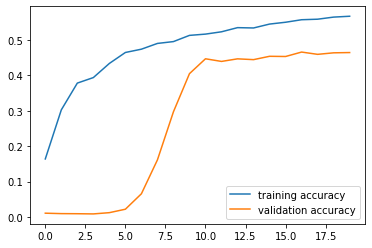

In [50]:
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

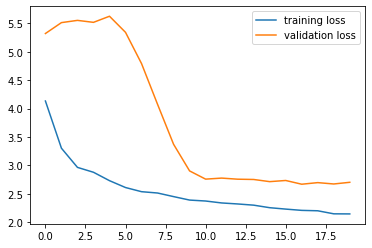

In [51]:
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [52]:
print("Evaluate model on test data")
results = model.evaluate(data_gen.flow(x_test, y_test), steps=10000//128)
print("test loss, test acc:", results)

Evaluate model on test data
78/78 [==============================] - 8s 92ms/step - loss: 1.2966 - accuracy: 0.6787
test loss, test acc: [1.2965734004974365, 0.6786859035491943]
